In [129]:
import requests
import psycopg2
import pandas as pd
import numpy as np
import sqlalchemy
from sqlalchemy import create_engine
import time
import spacy
import wikipedia
from spacy import displacy
nlp = spacy.load('en_core_web_sm')
#displacy.serve(doc, style='ent')
import configparser
import os
import warnings
warnings.filterwarnings("ignore")

In [131]:
pwd

'/Users/robinmasliah/Library/Mobile Documents/com~apple~CloudDocs/.Trash/spotify-project'

In [135]:
__file__ = '/Users/robinmasliah/Documents/GitHub/spotify-project/'
config = configparser.ConfigParser()
config.read(os.path.join(os.path.abspath(os.path.dirname(__file__)), 'config.ini'))

['/Users/robinmasliah/Documents/GitHub/spotify-project/config.ini']

In [137]:
hostname = config['bd_engine']['hostname']
username = config['bd_engine']['username']
password = config['bd_engine']['password']
database = config['bd_engine']['database']

CLIENT_ID = config['CLIENT']['CLIENT_ID']
CLIENT_SECRET = config['CLIENT']['CLIENT_SECRET']

In [138]:
conn_string = 'postgres://' + username + ':' + password + '@' + hostname + '/' + database
db = create_engine(conn_string)
conn = db.connect()

In [5]:
AUTH_URL = 'https://accounts.spotify.com/api/token'

# POST
auth_response = requests.post(AUTH_URL, {
    'grant_type': 'client_credentials',
    'client_id': CLIENT_ID,
    'client_secret': CLIENT_SECRET,
})

# convert the response to JSON
auth_response_data = auth_response.json()

# save the access token
access_token = auth_response_data['access_token']

headers = {
    'Authorization': 'Bearer {token}'.format(token=access_token)
}


# base URL of all Spotify API endpoints
BASE_URL = 'https://api.spotify.com/v1/'

In [586]:
names = ['Baila Reggeaton', 'El Ritmo', 'Puro Perreo', 'Mansion Reggeaton', 'Urbano Rising',
         'Perreo City', 'Fuego', 'Reggeaton Classics', 'Perrear y Llorar', 'Reggeaton Rewind',
         'Reggeaton Viejito', 'Suave', 'Academia Reggeaton', 'PEGAO', 'miticas', 'Reggeaton Chileno',
         'Reggeaton Argentino'
        ]
links = ['37i9dQZF1DWY7IeIP1cdjF', '37i9dQZF1DWVOLXBOylBUZ', 
         '37i9dQZF1DWX5ZOsG2Ogi1', '37i9dQZF1DWZjqjZMudx9T',
         '37i9dQZF1DX4OjfOteYnH8', '37i9dQZF1DWUlCmB8llCTB',
         '37i9dQZF1DX8sljIJzI0oo', '37i9dQZF1DX8SfyqmSFDwe',
         '37i9dQZF1DWXYWuNDAdJsw', '37i9dQZF1DXco4ODkIraMD',
         '37i9dQZF1DWWU6Rfto8Ppm', '37i9dQZF1DWSjuSq42neMu',
         '37i9dQZF1DXd8p9XRfIfUn', '37i9dQZF1DX1HCSfq0nSal',
         '37i9dQZF1DX2EiUAL7Wdfc', '37i9dQZF1DX5hIsIIk6w1F',
         '37i9dQZF1DX5hIsIIk6w1F'
        ]
ids = list(range(1, 18))

playlists_reggeaton = pd.DataFrame(
    {
        'id_playlist': ids,
        'playlists': names,
        'links': links
    }
)

In [6]:
# GET jsons of playlists
def playlists_jsons(playlist_id):

    time.sleep(20)
    r = requests.get(BASE_URL + 'playlists/' + playlist_id + '/tracks', 
                     headers=headers, 
                     params={'include_groups':'track'})
    d = r.json()
    
    return d

def flatten(t):
    return [item for sublist in t for item in sublist]

def get_playlist_artists_id(playlists_reggeaton):

    artists_playlist = []
    for i, content in enumerate(playlists_reggeaton['items']):
        artists_song = []
        for idx, json in enumerate(playlists_reggeaton['items'][i]['track']['artists']):
            artists_song.append(json['id'])
        artists_playlist.append(artists_song)
        
    artists_playlist = flatten(artists_playlist)
    artists_playlist = list(set(artists_playlist))
    
    return artists_playlist

def get_playlist_songs_id(playlists_reggeaton):
    
    #time.sleep(1)

    song_id_playlist = []
    for i, content in enumerate(playlists_reggeaton['items']):
        song_id_playlist.append(content['track']['id'])
    
    return song_id_playlist

def get_artist_name(artist_id):
    
    #time.sleep(1)
    
    r = requests.get(BASE_URL + 'artists/' + artist_id, 
                     headers=headers, 
                     params={'include_groups':'track'})
    d = r.json()
    
    return d['name']


def get_track_name(track_id):
    
    #time.sleep(1)
    
    r = requests.get(BASE_URL + 'tracks/' + track_id, headers=headers)
    d = r.json()
    
    return d['name']

def get_audio_features(track_id):
    
    #time.sleep(1)
    
    r = requests.get(BASE_URL + 'audio-features/' + track_id, headers=headers)
    track_features = r.json()
    
    return track_features

def get_audio_analysis(track_id):
    
    time.sleep(1)
    
    r = requests.get(BASE_URL + 'audio-analysis/' + track_id, headers=headers)
    audio_analysis = r.json()
    
    return audio_analysis


def build_table_features(playlist, label):
    
    list_tracks = []
    for i in playlist['items']:
        #print()
        dict_track = {}
        #print(i['track']['id'], i['track']['name'])
        
        try:

            dict_track['id_track'] = i['track']['id']
            dict_track['name_track'] = i['track']['name']
            dict_track['features_track'] = get_audio_features(i['track']['id'])


            dict_artists = {}
            for idx, content in enumerate(i['track']['artists']):
                #print(content['id'], content['name'])
                dict_artists['id_artist' + '_' + str(idx)] = content['id']
                dict_artists['name_artist' + '_' + str(idx)] = content['name']

            dict_artists_track = dict((key, value) for d in (dict_artists, dict_track) for key, value in d.items())
            list_tracks.append(dict_artists_track)
        
        except:
            pass
            
        try:
            df = pd.json_normalize(list_tracks)

            if label == 0 or label == 1:
                df['target'] = label
            else:
                pass
        except:
            pass

    return df

def get_wikipedia_page(artist):
    
    time.sleep(1)
    artist = artist.lower()
    print(artist)
    try:
        result = wikipedia.search(artist)
        page = wikipedia.page(result[0], auto_suggest=False)
    except:
        try:
            artist = artist + ' (singer)'
            result = wikipedia.search(artist)
            page = wikipedia.page(result[0], auto_suggest=False)
        except:
            text_page = 'None'
            return text_page
        
    text_page = page.content
    text_page = text_page.split('\n\n\n')[0]
    
    return text_page

def get_NER_wikipedia(text_page):
    
    doc = nlp(text_page)
    liste = []
    if doc.ents:
        for token in doc.ents:
            if (token.label_ == 'GPE' and get_continent(token.text) != ('Unknown', 'Unknown')) or token.label_ == 'NORP':
                #print(token.text, token.label_)
                liste.append(token.text)
    return liste

def get_country_nationality(potential_country, nationality_bdd):
    
    try:
        country = nationality_bdd['Country'][nationality_bdd['Nationality'] == potential_country].values[0]
    except:
        country = 'None'

    return country


def send_country_name(liste):
    
    for idx, potential_country in enumerate(liste):
        if get_country_nationality(potential_country, nationality_bdd) != 'None' or get_continent(potential_country) != ('Unknown', 'Unknown'):

            if get_country_nationality(potential_country, nationality_bdd) != 'None':
                name = get_country_nationality(potential_country, nationality_bdd)
            elif get_continent(potential_country) != ('Unknown', 'Unknown'):
                name = get_continent(potential_country)

            #print("Country : ", name)
            return name
            break
            
def get_continent(col):
    
    if type(col) == tuple:
        return (col)
    
    else:
        try:
            cn_a2_code =  country_name_to_country_alpha2(col)
        except:
            cn_a2_code = 'Unknown' 
        try:
            cn_continent = country_alpha2_to_continent_code(cn_a2_code)
        except:
            cn_continent = 'Unknown' 
        return (cn_a2_code, cn_continent)


#function to get longitude and latitude data 
from geopy.geocoders import Nominatim
geolocator = Nominatim()

def geolocate(country):
    
    try:
        # Geolocate the center of the country
        loc = geolocator.geocode(country)
        # And return latitude and longitude
        return (loc.latitude, loc.longitude)
    except:
        # Return missing value
        return np.nan

def get_countryname_with_code(name_country):
    if type(name_country) == tuple:
        
        coude_tuple = name_country
        name_country = pycountry.countries.get(alpha_2=coude_tuple[0])
        name_country = name_country.name 
        return name_country
    else:
        return name_country

In [6]:
playlists_reggeaton['json'] = playlists_reggeaton['links'].apply(lambda x: playlists_jsons(x))
playlists_reggeaton['artists'] = playlists_reggeaton['json'].apply(lambda x: get_playlist_artists_id(x))
playlists_reggeaton['songs'] = playlists_reggeaton['json'].apply(lambda x: get_playlist_songs_id(x))

In [7]:
playlists_reggeaton.to_sql('playlists', con=conn, 
                           if_exists='replace', index=False,
                           dtype={"id_playlist":sqlalchemy.types.Integer(),
                                  "playlists":sqlalchemy.types.STRINGTYPE,
                                  "links":sqlalchemy.types.STRINGTYPE,
                                  "json":sqlalchemy.types.JSON,
                                  "artists":sqlalchemy.types.JSON,
                                  "songs":sqlalchemy.types.JSON,
                                 
                                 })

In [8]:
conn = psycopg2.connect(conn_string)
try:
    SQL_Query = pd.read_sql_query(
        '''SELECT * FROM playlists;''', conn)

    df = pd.DataFrame(SQL_Query, columns=['id_playlist', 'playlists', 'links', 'json', 'artists', 'songs'])
    print('The data type of df is: ', type(df))
except:
    print("Error: unable to convert the data")

#conn.close()

The data type of df is:  <class 'pandas.core.frame.DataFrame'>


# Modèle recommandation

In [733]:
names = ['Buen Reggeaton', 'Mal Reggeaton', 'Salsa Cubana', 'Variete francaise', 'Cuecas Chilenas',
         'Musica Peruana', 'Black Lives Matter', 'Incontournables', 'Indispensables francais',
         'Piano Tranquile', 'Ludovico Einaudi', 'Atmospheric Piano', 'Reggeaton Hits',
         'Pop Urbaine', 'Valide', 'Fresh Rap', 'PUNCHLINERS', 'Best off US Rap', 'Classique Rap',
         'Rap US 2000', 'Rap US 2000 Vol.2', 'Gaming Rap US', 'Rap 2022', 'Guaracha 2022',
         'Hit Radio', 'Apero !', 'Alors on danse', 'Flashback', 'Disco', "a l'ancienne",
         'Alternative R&B', 'Funk outta here', '80s jam session', 'Metal Essentials',
         'Hellfet 2022', 'Heavy Metal', 'Global Groove', 'Flashback', 'Bossa Nova', 'Samba de Raiz',
         'Tropicalia', 'This is Frequency', 'Riple Effect', 'House Party', 'Heard You', 'One Love',
         'Israeli party', 'Kpop'
         ]

links = ['7bq37waj4hFMTZ6XEy4Db0', '330g098HZqqxUByG3FICzB',
         '37i9dQZF1DWVSSKiqqNKSC', '37i9dQZF1DXcSPhLAnCjoM',
         '7IVfZGK963zl7NvxUv1OPr', '6e5jDnWhQg72y3Aynq744b',
         '37i9dQZF1DWWAqc46ZJdZf', '37i9dQZF1DWYX0SFpLcPgx',
         '37i9dQZF1DX61tcJXPSFg7', '37i9dQZF1DX4FLflF8wPKE',
         '37i9dQZF1DWUofLlXqRWZz', '37i9dQZF1DWURCUKHUKWCX',
         '3fm4Brxt2u29y6Jm32wLJY', '37i9dQZF1DWYVURwQHUqnN',
         '37i9dQZF1DX4WpYT2fah9c', '37i9dQZF1DWU4xkXueiKGW',
         '37i9dQZF1DX1X23oiQRTB5', '5lNCNfSOwUlfxTED32G8Ff',
         '3sU60rLrcVv1g2LHeBY3AH', '2olAGUcxrrOCA42SmlxOaS',
         '7jaKOwABaOUPrv7NbTVsLM', '5QsPhQg0m1Q5LztA5dU2u7',
         '7qcdXKyfXkk7cBSQ2Fmwvn', '7LDpUAjCFTJVKPikrKVSJy',
         '37i9dQZF1DXbS5WTN5nKF7', '37i9dQZF1DWZk2SPZ3bugX',
         '37i9dQZF1DWUwJ0RFwrgQP', '37i9dQZF1DWXncK9DGeLh7',
         '37i9dQZF1DWTZQgENtHuxI', '37i9dQZF1DX9UuQbl12Nmb',
         '37i9dQZF1DWSfMe9z89s9B', '37i9dQZF1DX70TzPK5buVf',
         '37i9dQZF1DX0H8hDpv38Ju', '37i9dQZF1DWWOaP4H0w5b0',
         '37i9dQZF1DWZnlcbl9Edex', '37i9dQZF1DX9qNs32fujYe',
         '37i9dQZF1DWUS3jbm4YExP', '37i9dQZF1DWXncK9DGeLh7',
         '37i9dQZF1DX4AyFl3yqHeK', '37i9dQZF1DWTUHOvJwQIMp',
         '37i9dQZF1DXbEVW4FA74zM', '37i9dQZF1DWVgsJtp58d1t',
         '37i9dQZF1DX5qjSia2PLFP', '37i9dQZF1DXaaLM83puGG5',
         '37i9dQZF1DWVu3lAQuOIjU', '37i9dQZF1DWSiyIBdVQrkk',
         '20jHkvLZrSIOjuQBVurEms', '37i9dQZF1DX9tPFwDMOaN1'
         
         ]
ids = list(range(1, 49))

playlists_reggeaton = pd.DataFrame(
    {
        'id_playlist': ids,
        'playlists': names,
        'links': links
    }
)

In [734]:
playlists_reggeaton['json'] = playlists_reggeaton['links'].apply(lambda x: playlists_jsons(x))

In [762]:
playlists_reggeaton

id_playlist                playlists                   links  \
0             1           Buen Reggeaton  7bq37waj4hFMTZ6XEy4Db0   
1             2            Mal Reggeaton  330g098HZqqxUByG3FICzB   
2             3             Salsa Cubana  37i9dQZF1DWVSSKiqqNKSC   
3             4        Variete francaise  37i9dQZF1DXcSPhLAnCjoM   
4             5          Cuecas Chilenas  7IVfZGK963zl7NvxUv1OPr   
5             6           Musica Peruana  6e5jDnWhQg72y3Aynq744b   
6             7       Black Lives Matter  37i9dQZF1DWWAqc46ZJdZf   
7             8          Incontournables  37i9dQZF1DWYX0SFpLcPgx   
8             9  Indispensables francais  37i9dQZF1DX61tcJXPSFg7   
9            10          Piano Tranquile  37i9dQZF1DX4FLflF8wPKE   
10           11         Ludovico Einaudi  37i9dQZF1DWUofLlXqRWZz   
11           12        Atmospheric Piano  37i9dQZF1DWURCUKHUKWCX   
13           14              Pop Urbaine  37i9dQZF1DWYVURwQHUqnN   
14           15                   Valide  37i9dQZF1DX4WpYT2fah9c   
15           16                Fresh Rap  37i9dQZF1DWU4xkXueiKGW   
16           17              PUNCHLINERS  37i9dQZF1DX1X23oiQRTB5   
17           18          Best off US Rap  5lNCNfSOwUlfxTED32G8Ff   
22           23                 Rap 2022  7qcdXKyfXkk7cBSQ2Fmwvn   
23           24            Guaracha 2022  7LDpUAjCFTJVKPikrKVSJy   
24           25                Hit Radio  37i9dQZF1DXbS5WTN5nKF7   
25           26                  Apero !  37i9dQZF1DWZk2SPZ3bugX   
26           27           Alors on danse  37i9dQZF1DWUwJ0RFwrgQP   
27           28                Flashback  37i9dQZF1DWXncK9DGeLh7   
28           29                    Disco  37i9dQZF1DWTZQgENtHuxI   
29           30             a l'ancienne  37i9dQZF1DX9UuQbl12Nmb   
30           31          Alternative R&B  37i9dQZF1DWSfMe9z89s9B   
31           32          Funk outta here  37i9dQZF1DX70TzPK5buVf   
32           33          80s jam session  37i9dQZF1DX0H8hDpv38Ju   
33           34         Metal Essentials  37i9dQZF1DWWOaP4H0w5b0   
34           35             Hellfet 2022  37i9dQZF1DWZnlcbl9Edex   
35           36              Heavy Metal  37i9dQZF1DX9qNs32fujYe   
36           37            Global Groove  37i9dQZF1DWUS3jbm4YExP   
37           38                Flashback  37i9dQZF1DWXncK9DGeLh7   
38           39               Bossa Nova  37i9dQZF1DX4AyFl3yqHeK   
39           40            Samba de Raiz  37i9dQZF1DWTUHOvJwQIMp   
40           41               Tropicalia  37i9dQZF1DXbEVW4FA74zM   
41           42        This is Frequency  37i9dQZF1DWVgsJtp58d1t   
42           43             Riple Effect  37i9dQZF1DX5qjSia2PLFP   
43           44              House Party  37i9dQZF1DXaaLM83puGG5   
44           45                Heard You  37i9dQZF1DWVu3lAQuOIjU   
45           46                 One Love  37i9dQZF1DWSiyIBdVQrkk   
46           47            Israeli party  20jHkvLZrSIOjuQBVurEms   
47           48                     Kpop  37i9dQZF1DX9tPFwDMOaN1   

                                                 json  
0   {'href': 'https://api.spotify.com/v1/playlists...  
1   {'href': 'https://api.spotify.com/v1/playlists...  
2   {'href': 'https://api.spotify.com/v1/playlists...  
3   {'href': 'https://api.spotify.com/v1/playlists...  
4   {'href': 'https://api.spotify.com/v1/playlists...  
5   {'href': 'https://api.spotify.com/v1/playlists...  
6   {'href': 'https://api.spotify.com/v1/playlists...  
7   {'href': 'https://api.spotify.com/v1/playlists...  
8   {'href': 'https://api.spotify.com/v1/playlists...  
9   {'href': 'https://api.spotify.com/v1/playlists...  
10  {'href': 'https://api.spotify.com/v1/playlists...  
11  {'href': 'https://api.spotify.com/v1/playlists...  
13  {'href': 'https://api.spotify.com/v1/playlists...  
14  {'href': 'https://api.spotify.com/v1/playlists...  
15  {'href': 'https://api.spotify.com/v1/playlists...  
16  {'href': 'https://api.spotify.com/v1/playlists...  
17  {'href': 'https://api.spotify.com/v1/playlists...  
22 

In [763]:
playlists_reggeaton = playlists_reggeaton[playlists_reggeaton['json'] != {'error': {'status': 404, 'message': 'Not found.'}}]

In [772]:
dfs = np.split(playlists_reggeaton, [round(playlists_reggeaton.shape[0] / 2)], axis=0)

In [773]:
good = dfs[0]
bad = dfs[1]

In [774]:
good_jsons = list(good['json'])
bad_jsons = list(bad['json'])

In [779]:
list_datasets = []
for i in good_jsons:
    df = build_table_features(playlist=i, label=1)
    list_datasets.append(df)
good_ = pd.concat(list_datasets)
good_ = good_.reset_index(drop=True)

In [800]:
list_datasets = []
for i in bad_jsons:
    df = build_table_features(playlist=i, label=0)
    list_datasets.append(df)
bad_ = pd.concat(list_datasets)
bad_ = bad_.reset_index(drop=True)

In [805]:
good_.to_csv('good_.csv')
bad_.to_csv('bad_.csv')

In [802]:
data = pd.concat([good_, bad_])
data = data.fillna('None')
data = data.sample(frac=1).reset_index(drop=True)

In [803]:
print(data.shape)
data.head()

(2873, 73)


id_artist_0     name_artist_0             id_artist_1  \
0  3IJ21966TwNZI24MwZHMu4         Baby Tate                    None   
1  4DDlcMniR5obaLi3lcy8uI   Grupo Maravilla                    None   
2  5Y8g8xQA1pNHnnfFznkcqZ       Victor Solf  1s9CZWvJiTtwfhs1WevDDA   
3  4O6RDLeFX5xuQ7IePFzVcl  Demons & Wizards                    None   
4  6urzdpGY5yUimWZsgJUoTb         Airbourne                    None   

  name_artist_1                id_track     name_track  \
0          None  65HXJWOYBX2pFpdtusWRiV  Dancing Queen   
1          None  5KWhCMSUX1pdcngvVtAD0U      Antahuara   
2        Zefire  3rPWP9FwCB2vRDJcjGnx0a    How Did We?   
3          None  3QmT40QBlxr4n5AxhOSxkf       Diabolic   
4          None  1wXuogT7bvqnhuWzDBNOdV   Runnin' Wild   

  features_track.danceability features_track.energy features_track.key  \
0                       0.908                 0.559               11.0   
1                       0.713                 0.685                6.0   
2                       0.911                 0.501                8.0   
3                       0.283                 0.944               11.0   
4                        None                  None               None   

  features_track.loudness  ... id_artist_20 name_artist_20 id_artist_21  \
0                  -6.329  ...         None           None         None   
1                  -5.313  ...         None           None         None   
2                  -9.056  ...         None           None         None   
3                  -7.202  ...         None           None         None   
4                    None  ...         None           None         None   

  name_artist_21 id_artist_22 name_artist_22 id_artist_23 name_artist_23  \
0           None         None           None         None           None   
1           None         None           None         None           None   
2           None         None           None         None           None   
3           None         None           None         None           None   
4           None         None           None         None           None   

  id_artist_24 name_artist_24  
0         None           None  
1         None           None  
2         None           None  
3         None           None  
4         None           None  

[5 rows x 73 columns]

In [810]:
data['origin_artist'] = data['name_artist_0'].apply(lambda x: send_country_name(get_NER_wikipedia(get_wikipedia_page(x))))

baby tate
grupo maravilla
victor solf
demons & wizards
airbourne
bolémvn
the stance brothers
mariah the scientist
lykke li
owlle
kalash
nicky jam
cris mj
lionaire
the naked and famous
sarah watson
santigold
jef martens
edvard kravchuk
masked wolf
geraldine hunt
anthony b
nicky jam
lucas pazos
richard luke
nija
los gatos blancos
beth carvalho
robert de visée
daddy yankee
léa castel
masego
edvard kravchuk
maluma
akira kosemura
the brothers johnson
maihuen de los angeles
glass beams
kelow latesha
nuttea
valentin silvestrov
riton
eliad
gloria gaynor
omar apollo
martinho da vila
kwon eun bi
l'impératrice
ripple
beth carvalho
maihuen de los angeles
ed sheeran
gims
massianello
caracol televisión
trío añoranzas
amara ignacia
thelma houston
beth ditto
dj reys
charlotte adigéry
stretch
amon amarth
leto
dijahsb
kendrick lamar
jex nwalor
regard
four tops
cnco
the o'jays
ed sheeran
jay 305
charlotte cardin
sleepy hallow
jackson love
osvaldo montero
the notorious b.i.g.
juaneco y su combo
clara nune

In [811]:
data['origin_artist'] = data['origin_artist'].apply(lambda x: get_countryname_with_code(x))

In [812]:
data.to_sql('use_case', con=conn, if_exists='replace', index=False, chunksize=20)

In [9]:
data = pd.read_sql_query(
    '''SELECT * FROM use_case;''', conn)

#df = pd.DataFrame(SQL_Query, columns=['id_playlist', 'playlists', 'links', 'json', 'artists', 'songs'])

In [11]:
data = data[data['features_track.danceability'] != 'None']

In [14]:
data

id_artist_0             name_artist_0  \
0     3IJ21966TwNZI24MwZHMu4                 Baby Tate   
1     4DDlcMniR5obaLi3lcy8uI           Grupo Maravilla   
2     5Y8g8xQA1pNHnnfFznkcqZ               Victor Solf   
3     4O6RDLeFX5xuQ7IePFzVcl          Demons & Wizards   
5     0gGcw3tA1fZoF23qa8KFb7                   Bolémvn   
...                      ...                       ...   
2867  0ED4nwCVzVNO4epxO86cOR                Happy Face   
2869  3QFiymmbJlVBPpnrOatEAk                       Myd   
2870  4JSWO1Pf2zV991fq64uAce      Jean-Philippe Rameau   
2871  09o5k3t1L2ZxhJBnIERJxT  Los Wembler's de Iquitos   
2872  0KkJoXozXmbRdmpy7zCmYA       William Grant Still   

                 id_artist_1      name_artist_1                id_track  \
0                       None               None  65HXJWOYBX2pFpdtusWRiV   
1                       None               None  5KWhCMSUX1pdcngvVtAD0U   
2     1s9CZWvJiTtwfhs1WevDDA             Zefire  3rPWP9FwCB2vRDJcjGnx0a   
3                       None               None  3QmT40QBlxr4n5AxhOSxkf   
5     1q7T9rFQ2a2ukA1PU51fo3           Koba LaD  1mPommdCgPxwWW1pkoUkes   
...                      ...                ...                     ...   
2867                    None               None  3Panifq4x6Hj7wwN1ML2YV   
2869  3Sz7ZnJQBIHsXLUSo0OQtM        Mac DeMarco  3OrQzlqFmedMua5WxgCVrI   
2870  0iqgjl0OG3z53PZVIB7ZyD  Víkingur Ólafsson  1G3QPQkoXvpChjNUhd6Tfs   
2871                    None               None  4bViHO6pdrioBQnHxc7jhL   
2872  7wJT2nMGzUmQQLSIHbDaXU   Bruce Levingston  1XJMRdFSgkrmw2cXLJOD0b   

                        name_track features_track.danceability  \
0                    Dancing Queen                       0.908   
1                        Antahuara                       0.713   
2                      How Did We?                       0.911   
3                         Diabolic                       0.283   
5                        Chic choc                        0.75   
...                            ...                         ...   
2867                     Un Verano                       0.761   
2869                    Moving Men                       0.823   
2870        The Arts and the Hours                       0.415   
2871        La Danza Del Petrolero                       0.631   
2872  3 Visions: No. 2, Summerland                        0.46   

     features_track.energy features_track.key features_track.loudness  ...  \
0                    0.559               11.0                  -6.329  ...   
1                    0.685                6.0                  -5.313  ...   
2                    0.501                8.0                  -9.056  ...   
3                    0.944               11.0                  -7.202  ...   
5                    0.501               11.0                  -7.819  ...   
...                    ...                ...                     ...  ...   
2867                 0.612                9.0                  -3.522  ...   
2869                 0.664               10.0                  -8.673  ...   
2870                 0.026                1.0                   -36.7  ...   
2871                  0.88                4.0                  -6.703  ...   
2872               0.00618                6.0                 -28.121  ...   

     name_artist_20 id_artist_21 name_artist_21 id_artist_22 name_artist_22  \
0              None         None           None         None           None   
1              None         None           None         None           None   
2              None         None           None         None           None   
3              None         None           None         None           None   
5              None         None           None         None           None   
...             ...          ...            ...          ...            ...   
2867           None         None           None         None           None   
2869           None         None           None         N

# Map

In [15]:
# Import pandas library
import pandas as pd
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2
import folium
from folium.plugins import MarkerCluster

In [21]:
#nationality_bdd = pd.read_csv('demonyms.csv')
nationality_bdd = pd.read_sql_query(
    '''SELECT * FROM nationality;''', conn)
nationality_bdd.columns = ['Nationality', 'Country']
#nationality_bdd.to_sql('nationality', con=conn, if_exists='replace', index=False, chunksize=20)

In [22]:
countries = pd.DataFrame(data.origin_artist.value_counts(normalize=True))
countries = countries.reset_index()
countries.columns = ['CountryName', 'Artists_Percent']

In [23]:
countries['codes'] = countries['CountryName'].apply(lambda x: get_continent(x))
countries['CountryName'] = countries['CountryName'].apply(lambda x: get_countryname_with_code(x))
countries[['Country', 'Continent']] = pd.DataFrame(countries['codes'].tolist(), index=countries.index)
countries['Geolocate'] = countries['CountryName'].apply(lambda x: geolocate(x))
countries[['Latitude', 'Longitude']] = pd.DataFrame(countries['Geolocate'].tolist(), index=countries.index)

In [24]:
countries = countries[countries['Country'] != 'Unknown']
countries = countries.dropna()

In [25]:
world_map = folium.Map(tiles="cartodbpositron")
marker_cluster = MarkerCluster().add_to(world_map)#for each coordinate, create circlemarker of user percent
for i in range(len(countries)):
        lat = countries.iloc[i]['Latitude']
        long = countries.iloc[i]['Longitude']
        radius = 5
        popup_text = """Country : {}<br>
                    %of artists : {}<br>"""
        popup_text = popup_text.format(countries.iloc[i]['Country'],
                                   countries.iloc[i]['Artists_Percent']
                                   )
        folium.CircleMarker(location = [lat, long], 
                            radius=radius, popup=popup_text, 
                            fill=True).add_to(marker_cluster)#show the map
world_map

### END map

In [664]:
artists = data[data.columns[pd.Series(data.columns).str.startswith('name_artist')]]
artists = artists[['name_artist_0', 'name_artist_1']]
artists = artists[artists['name_artist_1'] != 'None']
#artists = artists.head(100)

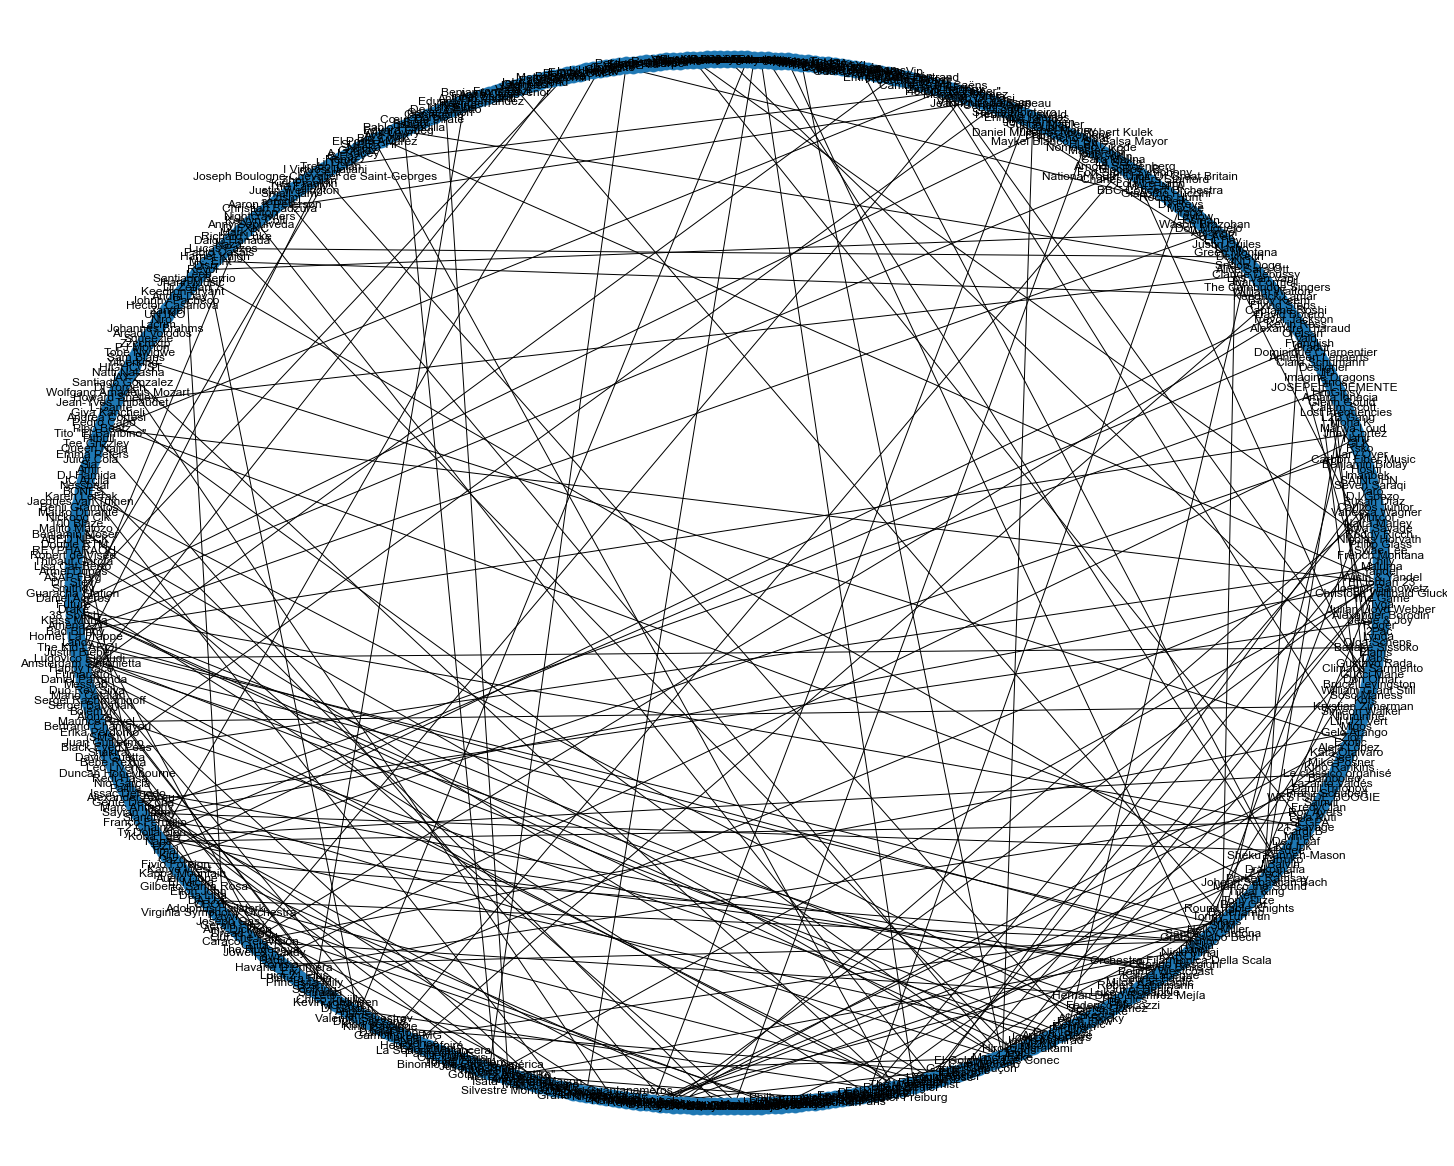

In [665]:
import networkx as nx
G = nx.Graph()
G = nx.from_pandas_edgelist(artists, 'name_artist_0', 'name_artist_1')

from matplotlib.pyplot import figure
figure(figsize=(20, 16))
nx.draw_shell(G, with_labels=True)

# Recommandation model

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30, 20)
import matplotlib
matplotlib.get_backend()
%matplotlib inline
plt.style.use('seaborn')
import re
import scikitplot as skplt

from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [27]:
def score_cross_val(scores):
    
    # Scores sur cross validation
    scores = pd.DataFrame(scores)
    scores.plot()

    plt.xlabel('CV')
    plt.ylabel('Score')
    plt.title("Scores sur le train de chaque cross validation")

    plt.axis()
    plt.legend("scores", loc='upper center')
    plt.show()

def plot_roc_auc_curve(model, X_test, y_test):
    
    # overall accuracy
    acc = model.score(X_test, y_test)

    # get roc/auc info
    # predict_proba is the porbability that X takes a class
    Y_score = model.predict_proba(X_test)[:, 1] 
    fpr = dict()
    tpr = dict()
    fpr, tpr, _ = roc_curve(y_test, Y_score)

    roc_auc = dict()
    roc_auc = auc(fpr, tpr)

    # make the plot
    plt.figure(figsize=(10, 10))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.plot(fpr, tpr, label='AUC = {0}'.format(roc_auc))
    plt.legend(loc="lower right", shadow=True, fancybox=True)
    plt.title('ROC curve and AUC')
    plt.show()


def plot_corr_matrix(df):
    
    data_correlation = df[list(df.columns)].corr()
    mask = np.array(data_correlation)
    mask[np.tril_indices_from(mask)] = False
    fig = plt.subplots(figsize=(30,20))
    sns.heatmap(data_correlation, mask=mask, vmax=1, square=True, annot=True);


In [28]:
data.head()

id_artist_0     name_artist_0             id_artist_1  \
0  3IJ21966TwNZI24MwZHMu4         Baby Tate                    None   
1  4DDlcMniR5obaLi3lcy8uI   Grupo Maravilla                    None   
2  5Y8g8xQA1pNHnnfFznkcqZ       Victor Solf  1s9CZWvJiTtwfhs1WevDDA   
3  4O6RDLeFX5xuQ7IePFzVcl  Demons & Wizards                    None   
5  0gGcw3tA1fZoF23qa8KFb7           Bolémvn  1q7T9rFQ2a2ukA1PU51fo3   

  name_artist_1                id_track     name_track  \
0          None  65HXJWOYBX2pFpdtusWRiV  Dancing Queen   
1          None  5KWhCMSUX1pdcngvVtAD0U      Antahuara   
2        Zefire  3rPWP9FwCB2vRDJcjGnx0a    How Did We?   
3          None  3QmT40QBlxr4n5AxhOSxkf       Diabolic   
5      Koba LaD  1mPommdCgPxwWW1pkoUkes      Chic choc   

  features_track.danceability features_track.energy features_track.key  \
0                       0.908                 0.559               11.0   
1                       0.713                 0.685                6.0   
2                       0.911                 0.501                8.0   
3                       0.283                 0.944               11.0   
5                        0.75                 0.501               11.0   

  features_track.loudness  ... name_artist_20 id_artist_21 name_artist_21  \
0                  -6.329  ...           None         None           None   
1                  -5.313  ...           None         None           None   
2                  -9.056  ...           None         None           None   
3                  -7.202  ...           None         None           None   
5                  -7.819  ...           None         None           None   

  id_artist_22 name_artist_22 id_artist_23 name_artist_23 id_artist_24  \
0         None           None         None           None         None   
1         None           None         None           None         None   
2         None           None         None           None         None   
3         None           None         None           None         None   
5         None           None         None           None         None   

  name_artist_24  origin_artist  
0           None  United States  
1           None           Cuba  
2           None         Russia  
3           None           None  
5           None         France  

[5 rows x 74 columns]

In [29]:
data.columns

Index(['id_artist_0', 'name_artist_0', 'id_artist_1', 'name_artist_1',
       'id_track', 'name_track', 'features_track.danceability',
       'features_track.energy', 'features_track.key',
       'features_track.loudness', 'features_track.mode',
       'features_track.speechiness', 'features_track.acousticness',
       'features_track.instrumentalness', 'features_track.liveness',
       'features_track.valence', 'features_track.tempo', 'features_track.type',
       'features_track.id', 'features_track.uri', 'features_track.track_href',
       'features_track.analysis_url', 'features_track.duration_ms',
       'features_track.time_signature', 'id_artist_2', 'name_artist_2',
       'id_artist_3', 'name_artist_3', 'id_artist_4', 'name_artist_4',
       'target', 'id_artist_5', 'name_artist_5', 'id_artist_6',
       'name_artist_6', 'id_artist_7', 'name_artist_7', 'id_artist_8',
       'name_artist_8', 'id_artist_9', 'name_artist_9', 'id_artist_10',
       'name_artist_10', 'id_artist_11',

In [30]:
df_reco = data[['name_artist_0', 'features_track.danceability', 'features_track.energy',
       'features_track.key', 'features_track.loudness', 'features_track.mode',
       'features_track.speechiness', 'features_track.acousticness',
       'features_track.instrumentalness', 'features_track.liveness',
       'features_track.valence', 'features_track.tempo', 'features_track.duration_ms',
       'features_track.time_signature', 'origin_artist', 'target']]

In [31]:
df_reco
df_reco = df_reco[df_reco['features_track.danceability'] != 'None']

In [77]:
df_eda.describe()

features_track.danceability  features_track.energy  features_track.key  \
count                  2278.000000            2278.000000         2278.000000   
mean                      0.656299               0.609934            5.471905   
std                       0.180564               0.249350            3.561598   
min                       0.061800               0.000860            0.000000   
25%                       0.560000               0.503250            2.000000   
50%                       0.703000               0.660000            6.000000   
75%                       0.787000               0.788000            9.000000   
max                       0.974000               0.996000           11.000000   

       features_track.loudness  features_track.mode  \
count              2278.000000          2278.000000   
mean                 -9.293218             0.522388   
std                   7.205585             0.499608   
min                 -44.526000             0.000000   
25%                  -9.725250             0.000000   
50%                  -6.928000             1.000000   
75%                  -5.356500             1.000000   
max                  -0.210000             1.000000   

       features_track.speechiness  features_track.acousticness  \
count                 2278.000000                  2278.000000   
mean                     0.107577                     0.312857   
std                      0.101500                     0.321232   
min                      0.024900                     0.000002   
25%                      0.043025                     0.045400   
50%                      0.060500                     0.190500   
75%                      0.129000                     0.499000   
max                      0.955000                     0.996000   

       features_track.instrumentalness  features_track.liveness  \
count                      2278.000000              2278.000000   
mean                          0.147635                 0.164865   
std                           0.309678                 0.128982   
min                           0.000000                 0.015400   
25%                           0.000000                 0.089325   
50%                           0.000070                 0.115000   
75%                           0.026150                 0.199000   
max                           0.986000                 0.976000   

       features_track.valence  features_track.tempo  \
count             2278.000000           2278.000000   
mean                 0.562015            117.930203   
std                  0.269444             27.333190   
min                  0.029300             55.481000   
25%                  0.353250             97.507500   
50%                  0.598000            117.904500   
75%                  0.789000            133.248250   
max                  0.982000            214.017000   

       features_track.duration_ms  features_track.time_signature  
count                 2278.000000                    2278.000000  
mean                219132.064530                       3.916155  
std                  66992.433773                       0.403643  
min                  41660.000000                       1.000000  
25%                 177175.000000                       4.000000  
50%                 206415.500000                       4.000000  
75%                 244000.000000                       4.000000  
max                 729627.000000                       5.000000

In [126]:
top_10_artists = list(data['name_artist_0'].value_counts()[0:10].index)
top_10_artists

['Ludovico Einaudi',
 'Maihuen de los Angeles',
 'Drake',
 'Nicky Jam',
 'Daddy Yankee',
 'Future',
 'LIONAIRE',
 'Antônio Carlos Jobim',
 'João Gilberto',
 'J Balvin']

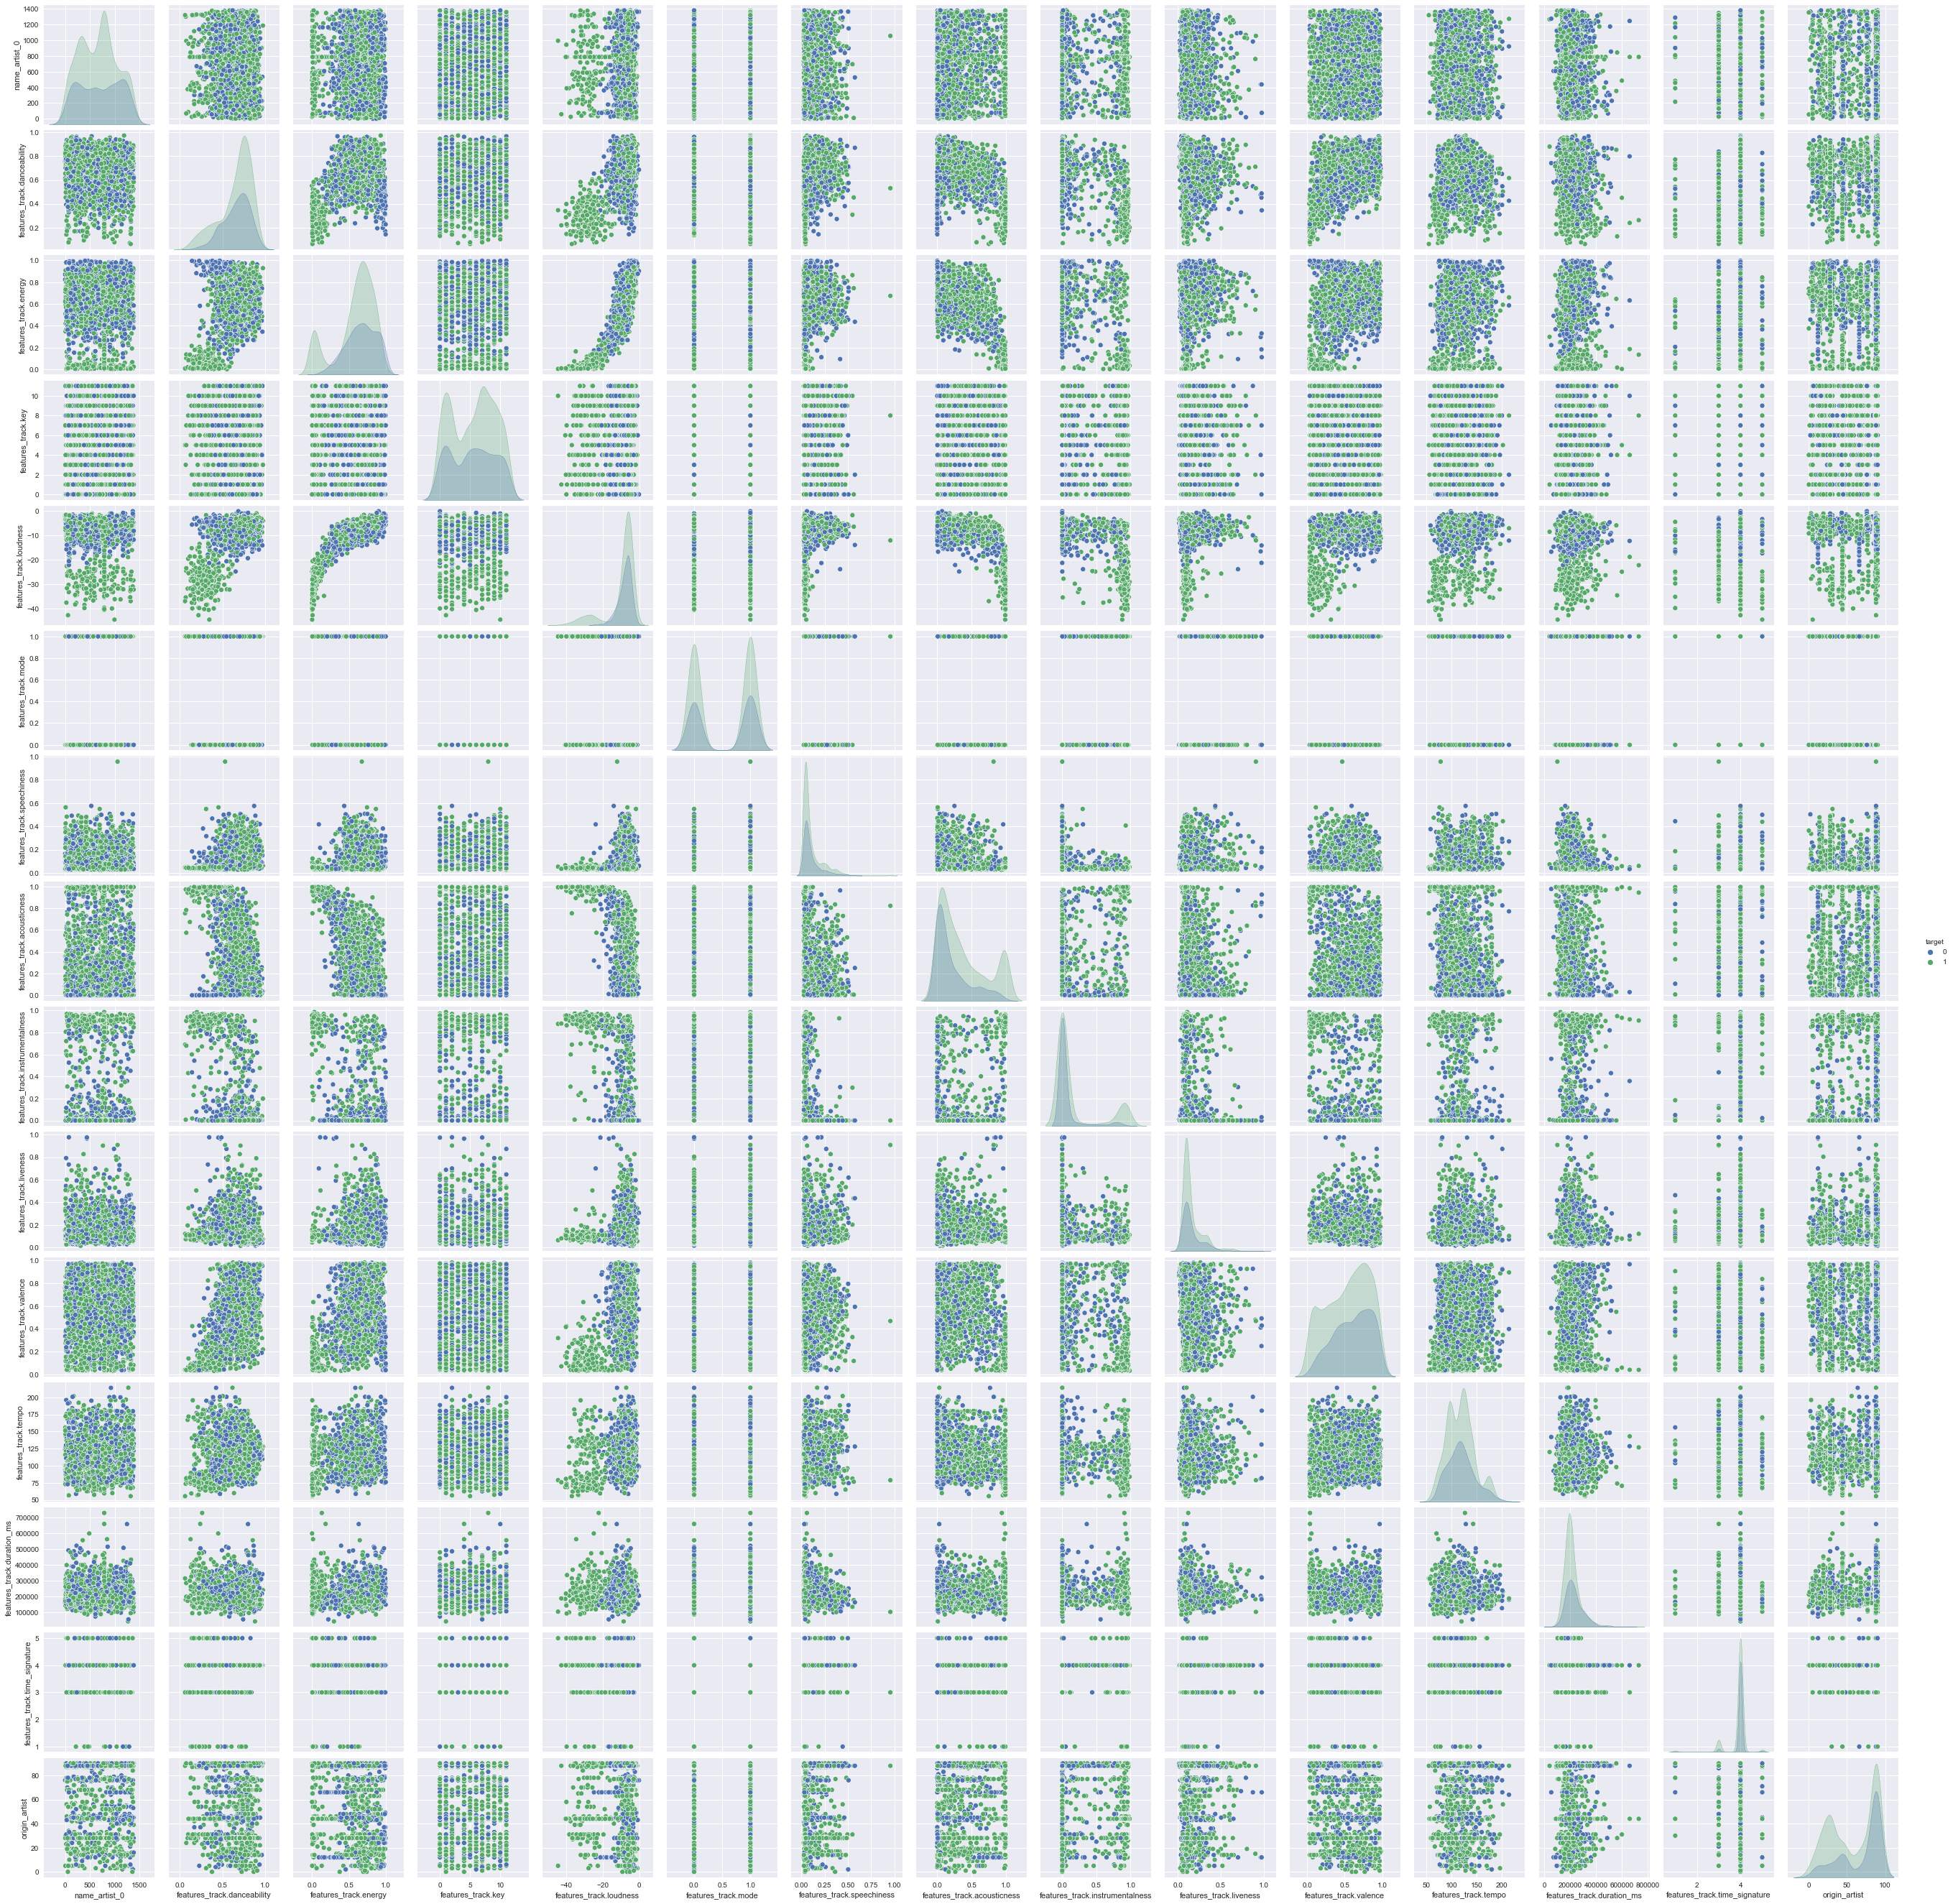

In [84]:
sns.pairplot(df_reco, hue='target')

<AxesSubplot:>

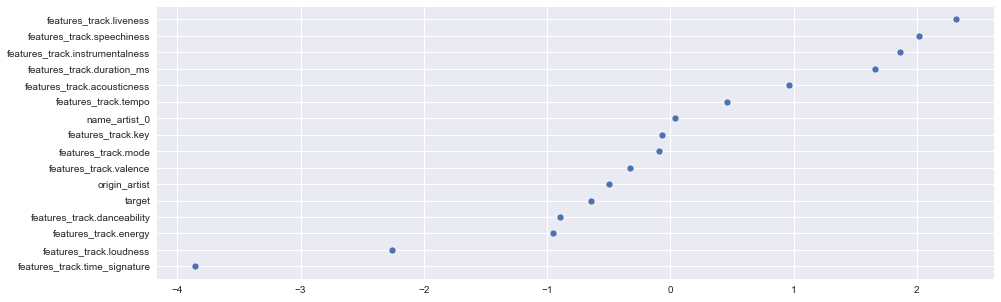

In [85]:
plt.figure(figsize=(15,5))
sns.scatterplot(df_reco.skew().sort_values(ascending=False), df_reco.skew().sort_values(ascending=False).index)

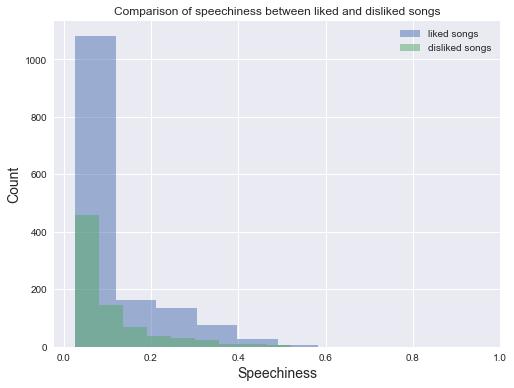

In [88]:
liked = df_reco['target'] == 1
disliked = df_reco['target'] == 0
liked_songs = df_reco[liked]
disliked_songs = df_reco[disliked]

plt.figure(figsize=(8,6))
plt.hist(liked_songs['features_track.speechiness'], alpha=0.5, label="liked songs")
plt.hist(disliked_songs['features_track.speechiness'], alpha=0.5, label="disliked songs")

plt.xlabel("Speechiness", size=14)
plt.ylabel("Count", size=14)
plt.title("Comparison of speechiness between liked and disliked songs")
plt.legend(loc='upper right')

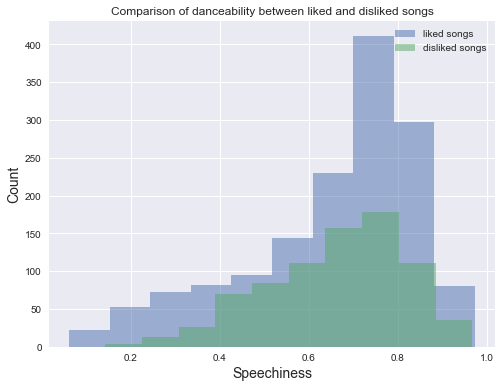

In [89]:
plt.figure(figsize=(8,6))
plt.hist(liked_songs['features_track.danceability'], alpha=0.5, label="liked songs")
plt.hist(disliked_songs['features_track.danceability'], alpha=0.5, label="disliked songs")

plt.xlabel("Speechiness", size=14)
plt.ylabel("Count", size=14)
plt.title("Comparison of danceability between liked and disliked songs")
plt.legend(loc='upper right')

Text(0, 0.5, 'Instrumentalness')

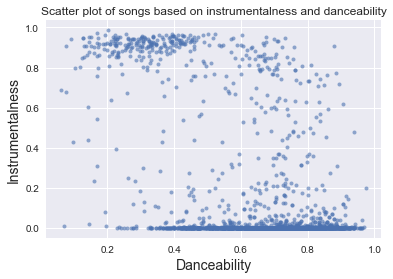

In [90]:
plt.plot(df_reco['features_track.danceability'], df_reco['features_track.instrumentalness'], 
         'o', markersize = 4, alpha=0.6)
plt.title("Scatter plot of songs based on instrumentalness and danceability")
plt.xlabel("Danceability", size=14)
plt.ylabel("Instrumentalness", size=14)

<AxesSubplot:title={'center':'Distribution of energy in songs'}, xlabel='features_track.energy', ylabel='Density'>

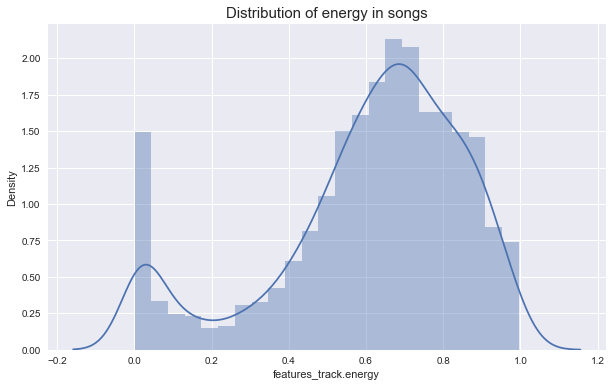

In [91]:
plt.figure(figsize=(10,6))
plt.title("Distribution of energy in songs", fontsize=15)
sns.distplot(df_reco['features_track.energy'])

Text(0.5, 1.0, 'Artist Name vs Count of songs')

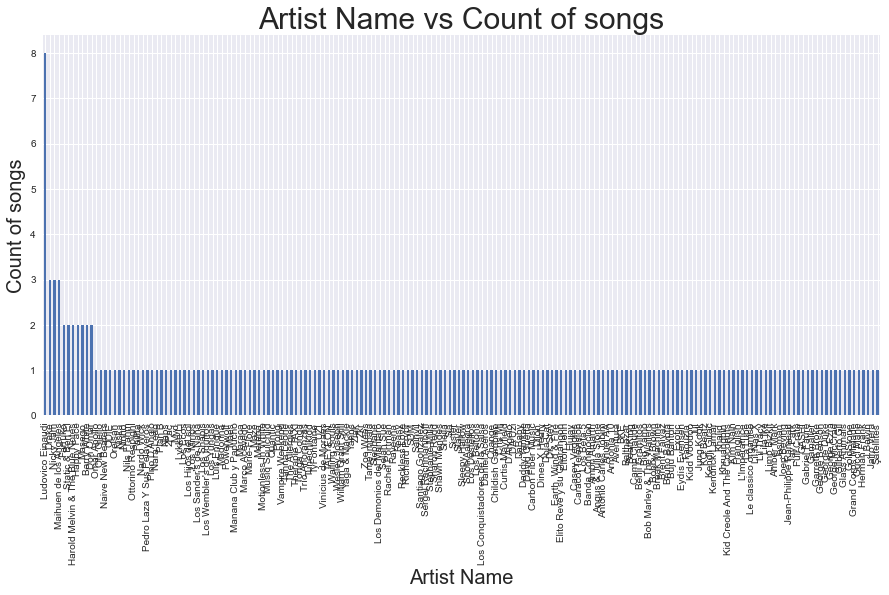

In [99]:
fig = plt.figure(figsize = (15,7))
data.tail(200).groupby('name_artist_0')['name_track'].agg(len).sort_values(ascending=False).plot(kind='bar')
plt.xlabel('Artist Name', fontsize=20)
plt.ylabel('Count of songs', fontsize=20)
plt.title('Artist Name vs Count of songs', fontsize=30)

<AxesSubplot:title={'center':'Dependence between acousticness and loudness'}, xlabel='features_track.acousticness', ylabel='features_track.loudness'>

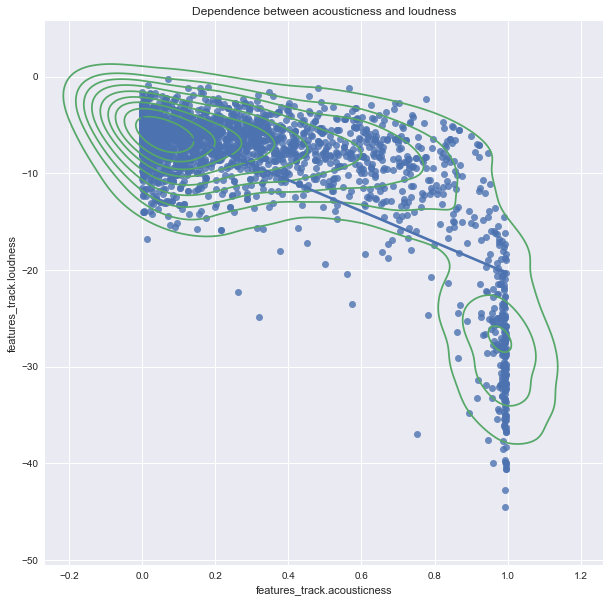

In [112]:
fig = plt.subplots(figsize=(10,10))
plt.title('Dependence between acousticness and loudness')
sns.regplot(x='features_track.acousticness', y='features_track.loudness',
            ci=None, data=df_reco)
sns.kdeplot(df_reco['features_track.acousticness'], df_reco['features_track.loudness'])

<AxesSubplot:xlabel='features_track.acousticness', ylabel='features_track.loudness'>

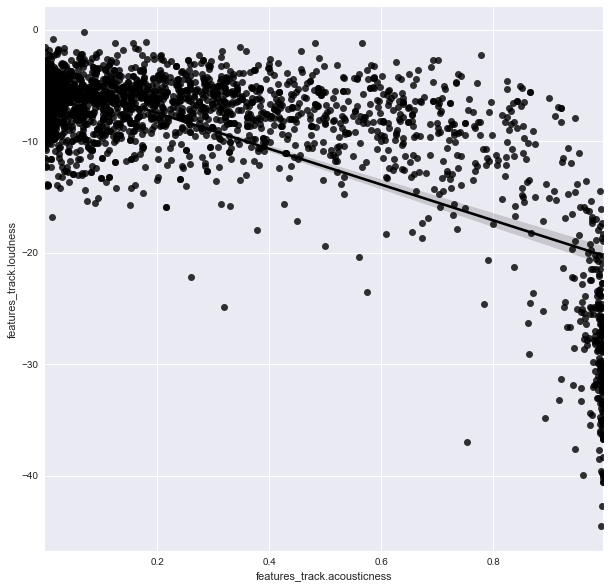

In [104]:
# Analysing the relationship between energy and loudness
fig = plt.subplots(figsize=(10,10))
sns.regplot(x='features_track.acousticness', y='features_track.loudness', data=df_reco ,color='black')

<AxesSubplot:xlabel='features_track.energy', ylabel='features_track.loudness'>

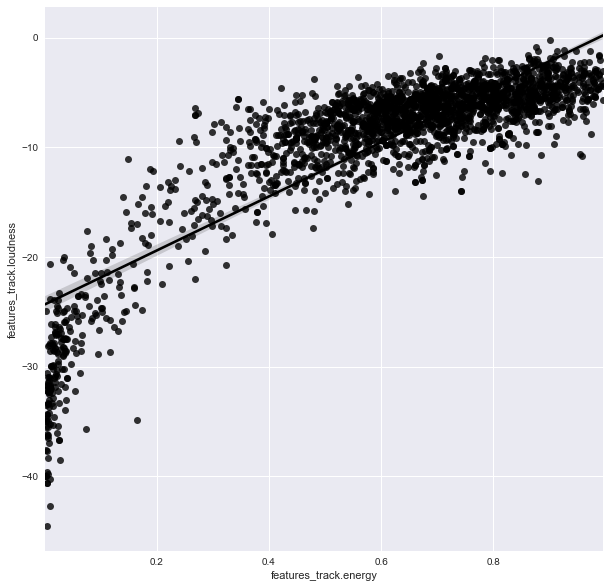

In [103]:
# Analysing the relationship between energy and loudness
fig = plt.subplots(figsize=(10,10))
sns.regplot(x='features_track.energy', y='features_track.loudness', data=df_reco ,color='black')

In [32]:
ord_enc = OrdinalEncoder()
df_reco["name_artist_0"] = ord_enc.fit_transform(df_reco[["name_artist_0"]])
df_reco["origin_artist"] = ord_enc.fit_transform(df_reco[["origin_artist"]])

In [33]:
df_reco.head()

name_artist_0 features_track.danceability features_track.energy  \
0          103.0                       0.908                 0.559   
1          480.0                       0.713                 0.685   
2         1306.0                       0.911                 0.501   
3          300.0                       0.283                 0.944   
5          151.0                        0.75                 0.501   

  features_track.key features_track.loudness features_track.mode  \
0               11.0                  -6.329                 1.0   
1                6.0                  -5.313                 1.0   
2                8.0                  -9.056                 0.0   
3               11.0                  -7.202                 0.0   
5               11.0                  -7.819                 0.0   

  features_track.speechiness features_track.acousticness  \
0                      0.333                     0.00656   
1                     0.0337                       0.825   
2                      0.134                       0.159   
3                       0.18                     0.00163   
5                      0.386                       0.321   

  features_track.instrumentalness features_track.liveness  \
0                             0.0                   0.234   
1                         0.00399                  0.0915   
2                          0.0175                  0.0943   
3                           0.234                   0.101   
5                             0.0                   0.113   

  features_track.valence features_track.tempo features_track.duration_ms  \
0                  0.616              143.993                   193076.0   
1                  0.966              105.589                   222119.0   
2                  0.917               107.95                   199333.0   
3                 0.0681              147.989                   481125.0   
5                  0.731              141.992                   191419.0   

  features_track.time_signature  origin_artist  target  
0                           4.0           88.0       0  
1                           4.0           19.0       1  
2                           4.0           70.0       1  
3                           4.0           90.0       0  
5                           4.0           28.0       1

In [34]:
df_reco = df_reco.apply(pd.to_numeric)

In [51]:
df_reco.target.value_counts(normalize=True)

1    0.653205
0    0.346795
Name: target, dtype: float64

In [35]:
df_reco.describe()

name_artist_0  features_track.danceability  features_track.energy  \
count    2278.000000                  2278.000000            2278.000000   
mean      675.935909                     0.656299               0.609934   
std       385.759801                     0.180564               0.249350   
min         0.000000                     0.061800               0.000860   
25%       329.250000                     0.560000               0.503250   
50%       696.000000                     0.703000               0.660000   
75%       975.750000                     0.787000               0.788000   
max      1383.000000                     0.974000               0.996000   

       features_track.key  features_track.loudness  features_track.mode  \
count         2278.000000              2278.000000          2278.000000   
mean             5.471905                -9.293218             0.522388   
std              3.561598                 7.205585             0.499608   
min              0.000000               -44.526000             0.000000   
25%              2.000000                -9.725250             0.000000   
50%              6.000000                -6.928000             1.000000   
75%              9.000000                -5.356500             1.000000   
max             11.000000                -0.210000             1.000000   

       features_track.speechiness  features_track.acousticness  \
count                 2278.000000                  2278.000000   
mean                     0.107577                     0.312857   
std                      0.101500                     0.321232   
min                      0.024900                     0.000002   
25%                      0.043025                     0.045400   
50%                      0.060500                     0.190500   
75%                      0.129000                     0.499000   
max                      0.955000                     0.996000   

       features_track.instrumentalness  features_track.liveness  \
count                      2278.000000              2278.000000   
mean                          0.147635                 0.164865   
std                           0.309678                 0.128982   
min                           0.000000                 0.015400   
25%                           0.000000                 0.089325   
50%                           0.000070                 0.115000   
75%                           0.026150                 0.199000   
max                           0.986000                 0.976000   

       features_track.valence  features_track.tempo  \
count             2278.000000           2278.000000   
mean                 0.562015            117.930203   
std                  0.269444             27.333190   
min                  0.029300             55.481000   
25%                  0.353250             97.507500   
50%                  0.598000            117.904500   
75%                  0.789000            133.248250   
max                  0.982000            214.017000   

       features_track.duration_ms  features_track.time_signature  \
count                 2278.000000                    2278.000000   
mean                219132.064530                       3.916155   
std                  66992.433773                       0.403643   
min                  41660.000000                       1.000000   
25%                 177175.000000                       4.000000   
50%                 206415.500000                       4.000000   
75%                 244000.000000                       4.000000   
max                 729627.000000                       5.000000   

       origin_artist       target  
count    2278.000000  2278.000000  
mean       61.554434     0.653205  
std        29.275101     0.476054  
min         0.000000     0.000000  
25%        31.000000     0.000000  
50%        76.000000     1.000000  
75%        88.000000     1.000000  
max        90.000000     1.000000

In [36]:
df_reco.shape

(2278, 16)

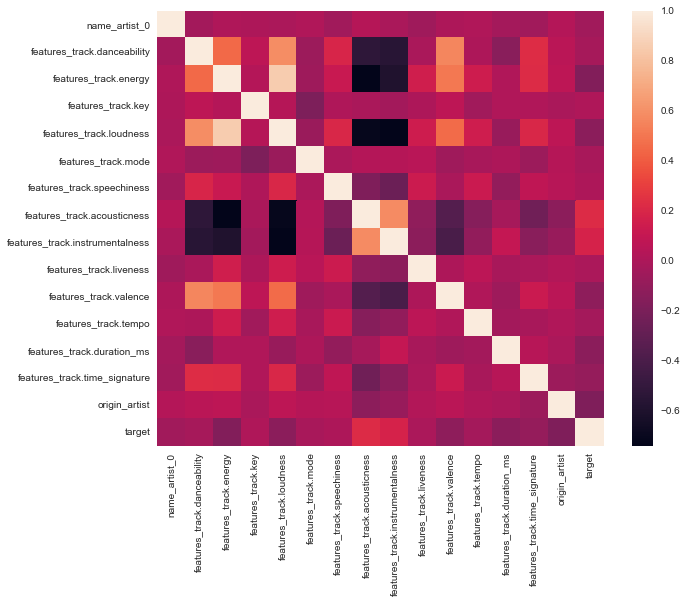

In [37]:
# Etude des corrélations entre les features
f, ax = plt.subplots(figsize=(10, 8))
corr = df_reco.corr()
sns.heatmap(corr);

In [53]:
X = df_reco.loc[:, df_reco.columns != 'target']
y = df_reco['target']

In [54]:
from imblearn.over_sampling import ADASYN
# Over-sampling
ada = ADASYN(sampling_strategy='minority')
X_resampled, y_resampled = ada.fit_sample(X, y)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [70]:
xgb = XGBClassifier(max_depth=4,
                    learning_rate=0.1,
                    n_estimators=150)

xgb.fit(X_train, y_train)
scores = cross_val_score(xgb, X_train, y_train, cv=10)
y_pred_xgb = xgb.predict(X_test)
y_pred_xgb_probas = xgb.predict_proba(X_test)
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred_xgb))
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_xgb)
print(cf_matrix)

Accuracy: 0.863
[[250  39]
 [ 43 267]]


In [71]:
print(accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

0.8631051752921536
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       289
           1       0.87      0.86      0.87       310

    accuracy                           0.86       599
   macro avg       0.86      0.86      0.86       599
weighted avg       0.86      0.86      0.86       599



In [72]:
score_cross_val(scores)

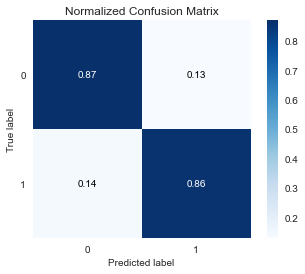

In [73]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred_xgb, normalize=True)
plt.show()

In [74]:
plot_roc_auc_curve(xgb, X_test, y_test)